In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import optuna
import seaborn as sns
import pickle
from matplotlib.ticker import FuncFormatter
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, accuracy_score, roc_auc_score
from sklearn.calibration import CalibrationDisplay
from data.shots_data_retriever import ShotsDataRetriever

In [3]:
shotsDataRetriever = ShotsDataRetriever()
df = shotsDataRetriever.get_df_for_milestone2_part4()

In [4]:
print(df.groupby('is_goal').size())
df

is_goal
0    265840
1     28669
dtype: int64


,game_id,play_num,period,is_goal,x_coord,y_coord,shot_type,is_empty_net,distance,angle_to_goal,...,last_event_x_coord,last_event_y_coord,time_since_last_event,distance_from_last_event,rebound,angle_change,speed,time_since_powerplay,away_skaters,home_skaters
0,2016020001,7,1,0,77,5,wrist,0,13.928388,21.037511,...,61,11,1,17.088007,False,0.000000,17.088007,0,5,5
1,2016020001,14,1,0,86,13,wrist,0,13.601471,72.897271,...,54,-5,5,36.715120,False,0.000000,7.343024,0,5,5
2,2016020001,21,1,0,23,-38,wrist,0,77.025970,-29.560354,...,72,0,18,62.008064,False,0.000000,3.444892,0,5,5
3,2016020001,23,1,0,33,-15,slap,0,58.940648,-14.743563,...,77,-2,19,45.880279,False,0.000000,2.414752,0,5,5
4,2016020001,36,1,0,34,28,wrist,0,62.609903,26.565051,...,47,34,16,14.317821,False,0.000000,0.894864,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68060,2019021082,283,3,0,77,-23,backhand,0,26.419690,-60.524111,...,72,-21,21,5.385165,False,0.000000,0.256436,0,5,5
68061,2019021082,285,3,0,76,38,slap,0,40.496913,69.775141,...,95,-17,16,58.189346,False,0.000000,3.636834,0,5,5
68062,2019021082,286,3,0,79,10,backhand,0,14.866069,42.273689,...,76,38,2,28.160256,True,27.501452,14.080128,0,5,5
68063,2019021082,293,3,0,81,-7,snap,0,11.401754,-37.874984,...,60,40,32,51.478151,False,0.000000,1.608692,0,6,5


In [5]:
cv_folds = 3

### XGBClassifier v0:
- Trained on `angle_to_goal` and `distance`
- No hyperparameter tuning

In [6]:
X0 = df[['angle_to_goal', 'distance']]
y = df['is_goal']

X_train_0, X_val_0, y_train, y_val = train_test_split(X0, y, test_size=0.3, random_state=1)


In [9]:
wandb.init(
    project="IFT6758.2024-A02",
    name="xgboost-not_tuned",
    config={
        "model": "XGBClassifier",
    }
)

xgboost_v0 = XGBClassifier()
xgboost_v0.fit(X_train_0, y_train)

model_path = "xgboost_v0_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(xgboost_v0, f)
    
wandb.log_model(path=model_path, name="xgboost_v0_model")

y_pred = xgboost_v0.predict(X_val_0)
y_pred_prob = xgboost_v0.predict_proba(X_val_0)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc,
})

results_v0 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})

wandb.log({"results-not_tuned": wandb.Table(dataframe=results_v0)})

wandb.finish()
os.remove(model_path)

accuracy,▁
roc_auc,▁
accuracy,0.90126
roc_auc,0.71096


### XGBClassifier v1:
- Trained on all features
- Hyperparameters optimized

In [10]:
df1 = pd.get_dummies(df.drop(columns=['game_id', 'play_num']), columns=['shot_type'])
X1 = df1.drop(columns=['is_goal'])
y = df1['is_goal']

X_train_1, X_val_1, y_train, y_val = train_test_split(X1, y, test_size=0.3, random_state=1)

#### Scoring metric

There is a notable class imbalance in the dataset - 276763 class 0 data points for 29006 class 1 data points. Further - we are not interested in the classifier's ability to correctly label a shot as a goal or not. Instead, we are more focused on creating a classifier able to predict a realistic probability of goal. Given these requirements, I will choose **log-loss** as my scoring metric.

#### Hyperparameter optimization method
I do not have much experience optimizing XGBoost models and so do not have an intuition for which hyperparameter values to explore. Thus, I will **Bayesian Optimization** as it is capable of intelligently exploring different hyperparameter values without requiring them to be set ahead of time.

In [11]:
wandb.init(
    project="IFT6758.2024-A02",
    name="xgboost-tuned",
    config={
        "cv_folds": cv_folds,
        "eval_metric": "logloss",
        "model": "XGBClassifier",
    },
    reinit=True
)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = XGBClassifier(**params, eval_metric='logloss')
    
    score = cross_val_score(model, X_train_1, y_train, scoring='neg_log_loss', cv=cv_folds).mean()
    
    wandb.log({
        "trial_number": trial.number,
        "n_estimators": params['n_estimators'],
        "max_depth": params['max_depth'],
        "learning_rate": params['learning_rate'],
        "colsample_bytree": params['colsample_bytree'],
        "subsample": params['subsample'],
        "min_child_weight": params['min_child_weight'],
        "neg_log_loss": score
    })
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

wandb.config.update(study.best_params)

xgboost_v1 = XGBClassifier(**study.best_params, eval_metric='logloss')
xgboost_v1.fit(X_train_1, y_train)

model_path = "xgboost_v1_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(xgboost_v1, f)
    
wandb.log_model(path=model_path, name="xgboost_v1_model")

y_pred = xgboost_v1.predict(X_val_1)
y_pred_prob = xgboost_v1.predict_proba(X_val_1)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc,
})
print(f"Accuracy: {accuracy}", f"ROC AUC: {roc_auc}")

results_v1 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})
wandb.log({"results-tuned": wandb.Table(dataframe=results_v1)})

print("Best parameters:", study.best_params)

wandb.finish()
os.remove(model_path)

[I 2024-11-21 10:07:31,239] A new study created in memory with name: no-name-618c7516-b46b-4b47-b586-c05c7e8403cb
[I 2024-11-21 10:07:45,692] Trial 0 finished with value: -0.27514183859307006 and parameters: {'n_estimators': 252, 'max_depth': 10, 'learning_rate': 0.10765837808217245, 'colsample_bytree': 0.8475057310447145, 'subsample': 0.9393106781703737, 'min_child_weight': 3}. Best is trial 0 with value: -0.27514183859307006.
[I 2024-11-21 10:07:56,654] Trial 1 finished with value: -0.26691335167554026 and parameters: {'n_estimators': 335, 'max_depth': 4, 'learning_rate': 0.033005123064875214, 'colsample_bytree': 0.8292163789110054, 'subsample': 0.6212952828975561, 'min_child_weight': 8}. Best is trial 1 with value: -0.26691335167554026.
[I 2024-11-21 10:08:07,747] Trial 2 finished with value: -0.27890426025760323 and parameters: {'n_estimators': 191, 'max_depth': 10, 'learning_rate': 0.16193593038151813, 'colsample_bytree': 0.5570472065808993, 'subsample': 0.7441249299556625, 'min_c

Accuracy: 0.9063529251977862 ROC AUC: 0.7780615813223477
Best parameters: {'n_estimators': 108, 'max_depth': 7, 'learning_rate': 0.07289413398267136, 'colsample_bytree': 0.8135224419562904, 'subsample': 0.9100633620333523, 'min_child_weight': 2}


accuracy,▁
colsample_bytree,▆▆▂█▃▂▇▇█▆▇▅▆▅▃▃▄▃▁▅▄▇▅█▆▅▆▅▅▅▇▅▇▇▇▆▆▅▅▄
learning_rate,▃▁▅▇▂▆▆▆▃█▂▃▄▂▅▄▅▂▃▂▄▂▁▃▄▃▅▂▂▁▂▁▂▂▁▂▃▂▇▂
max_depth,█▂██▂▂▇▁▄▁▁▃▆▅▁▃▅▁▁▂▂▃▁▂▁▂▂▂▃▃▃▄▃▂▂▄▄▅▅▆
min_child_weight,▃▆▅█▅▄▅▂▇█▆▇▆▃▇▆▆▁▇▆█▇▆▆▇▃▃▃▃▃▄▃▂▂▂▁▁▂▁▃
n_estimators,▄▅▃▂▄▂▅▄▆█▆▇▆█▇▇▆▆▅▇▆▇▅▄▄▆▆▅▄▄▄▃▂▄▄▂▁▂▁▃
neg_log_loss,▆█▅▄█▇▇▂█▁██▇▇▅█▇▄████▇█▇▇████████████▇█
roc_auc,▁
subsample,▇▃▄▂▃▄▄▆▁▁▃▂▂▆▃▃▅▂▄▂▃▂▅█▃▂▄▄▅▃▃▅▄▃▃▇▇▇▇▇
trial_number,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
accuracy,0.90635


### XGBClassifier v2:
- Numeric data scaled
- Trained on select features
- Hyperparameters tuned

### Sklearn
Created a feature engineering pipeline that scales numeric values and selects k-best features.

Created an overall pipeline that goes through the feature engineering pipeline and then fits the optimized xgboost model with the new data.

In [12]:
wandb.init(project="IFT6758.2024-A02", name="xgboost-featured_engineered_and_tuned")

wandb.config = {
    "model": "XGBClassifier",
    "scoring_metric": "roc_auc",
    "cv_folds": cv_folds,
    "feature_selection": "mutual_info_classif",
    "classifier_params": study.best_params
}

numeric_features = [
    'period', 'x_coord', 'y_coord', 'is_empty_net', 'distance', 
    'angle_to_goal', 'game_seconds', 'last_event_x_coord', 
    'last_event_y_coord', 'time_since_last_event', 
    'distance_from_last_event', 'rebound', 'angle_change', 'speed'
]

boolean_features = [col for col in X_train_1.columns if col.startswith('shot_type_')]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bool', 'passthrough', boolean_features)
    ]
)

feature_engineering_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectKBest(mutual_info_classif, k='all'))
])

pipeline = Pipeline([
    ('feature_engineering', feature_engineering_pipeline),
    ('classifier', xgboost_v1)
])

pipeline.fit(X_train_1, y_train)

y_pred = pipeline.predict(X_val_1)
y_pred_prob = pipeline.predict_proba(X_val_1)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc
})

print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Final Model ROC AUC: {roc_auc:.4f}")

results_v2 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})

wandb.log({"results-featured_engineered_and_tuned": wandb.Table(dataframe=results_v2)})

xgboost_v2 = pipeline.named_steps['classifier']

model_path = "xgboost_v2_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(xgboost_v2, f)
    
wandb.log_model(path=model_path, name="xgboost_v2_model")

wandb.finish()
os.remove(model_path)

Final Model Accuracy: 0.9066
Final Model ROC AUC: 0.7752


accuracy,▁
roc_auc,▁
accuracy,0.9066
roc_auc,0.77519


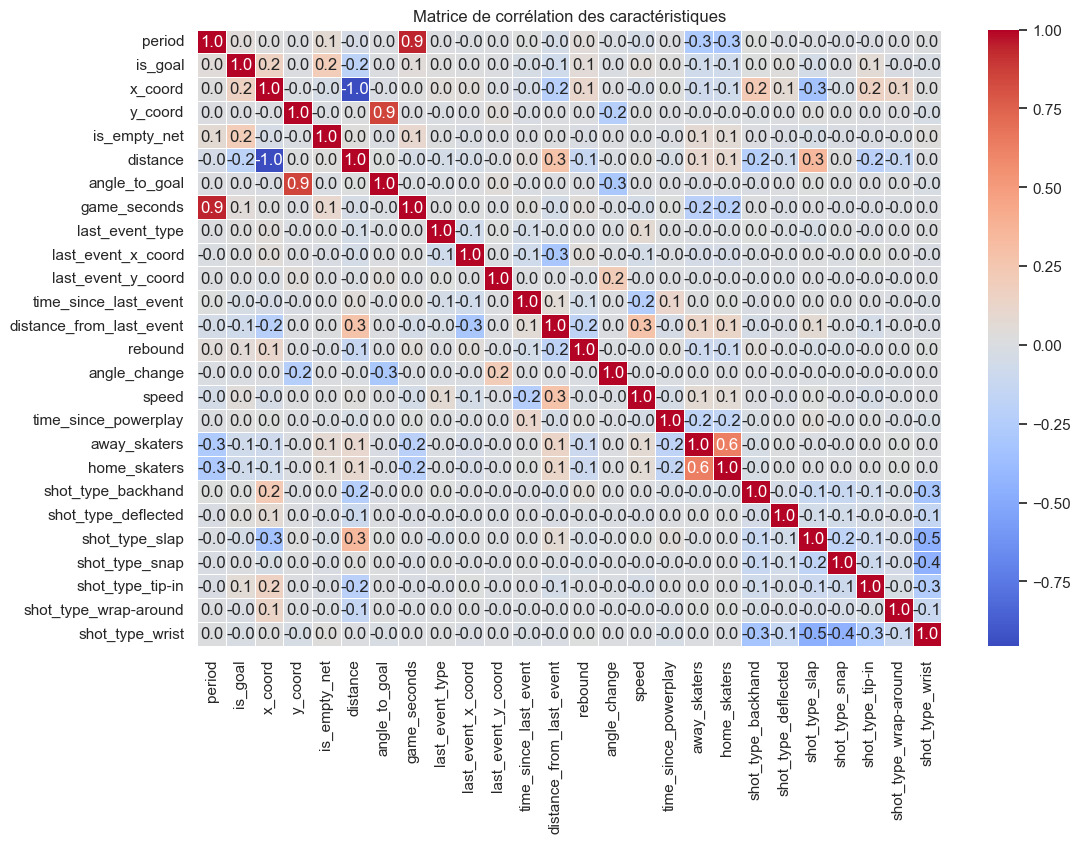

In [15]:
figpath = "../../figures/models/xgboost"
if not os.path.exists(figpath):
    os.makedirs(figpath)

corr_matrix = df1.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Matrice de corrélation des caractéristiques')

plt.savefig(os.path.join(figpath, "correlation_matrix.png"))
plt.show()

C:\Users\Daniel\AppData\Local\Temp\ipykernel_14700\3605110363.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


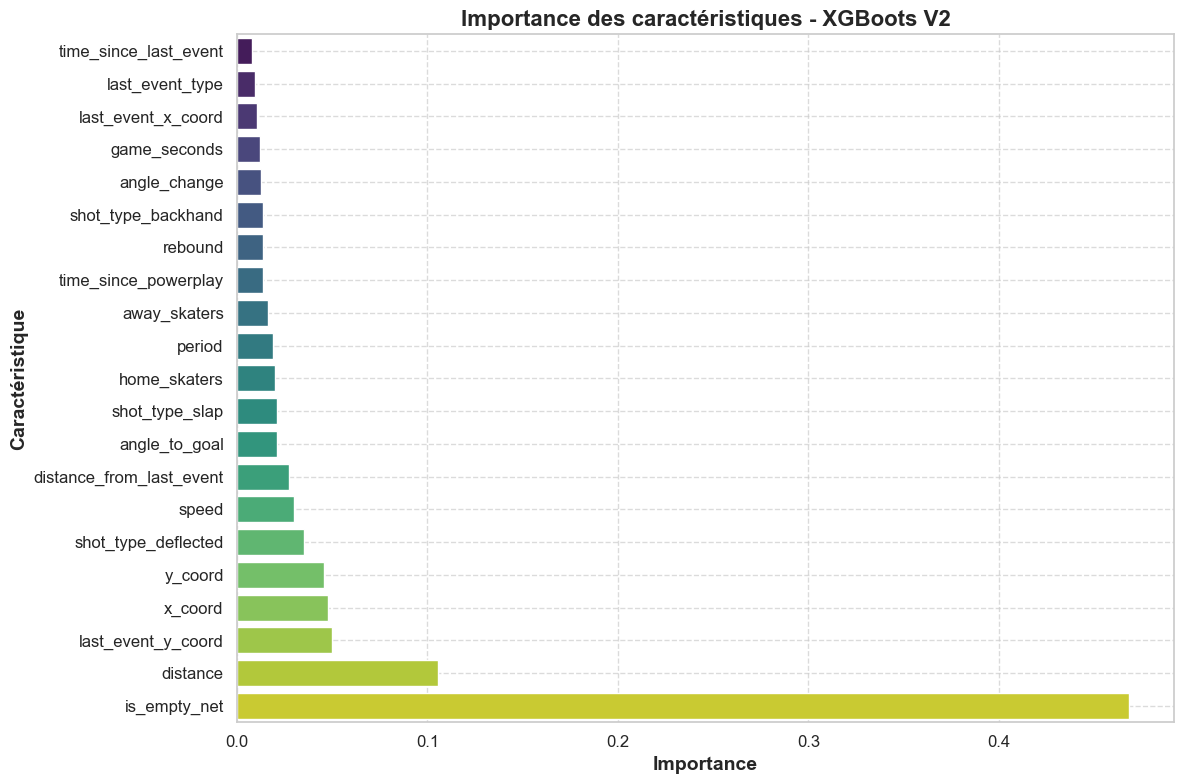

In [16]:
sns.set_theme(style="whitegrid")

importances = xgboost_v2.feature_importances_

selected_features = pipeline.named_steps['feature_engineering'].named_steps['feature_selection'].get_support(indices=True)
selected_feature_names = [X_train_1.columns[i] for i in selected_features]

feature_importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': importances[selected_features]
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x="importance", 
    y="feature", 
    data=feature_importance_df, 
    palette="viridis",
    orient="h"
)

ax.set_xlabel('Importance', fontsize=14, weight='bold')
ax.set_ylabel('Caractéristique', fontsize=14, weight='bold')
ax.set_title('Importance des caractéristiques - XGBoots V2', fontsize=16, weight='bold')

ax.tick_params(axis='both', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(figpath, "importance_carac.png"))
plt.show()

### Plots

<Figure size 640x480 with 0 Axes>

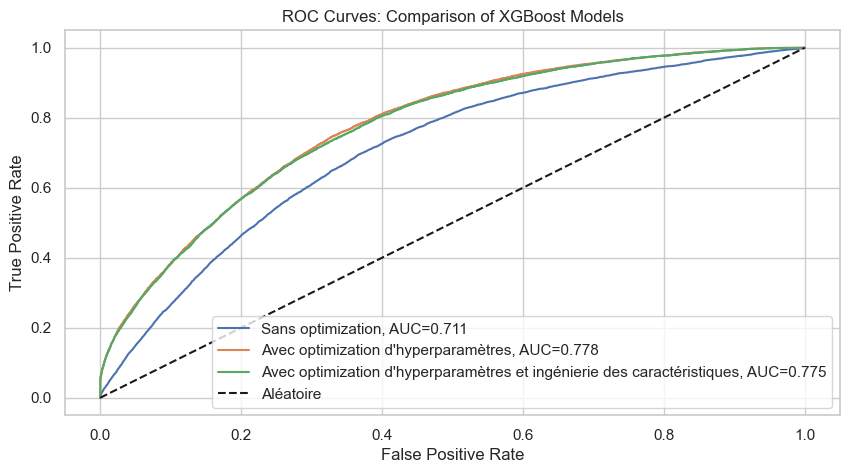

In [17]:
plt.figure(0).clf()
plt.figure(figsize=(10, 5))

fpr, tpr, thresh = metrics.roc_curve(results_v0['is_goal'], results_v0['goal_proba'])
auc = metrics.roc_auc_score(results_v0['is_goal'], results_v0['goal_proba'])
plt.plot(fpr, tpr, label="Sans optimization, AUC=" + f"{auc:.3f}")

fpr, tpr, thresh = metrics.roc_curve(results_v1['is_goal'], results_v1['goal_proba'])
auc = metrics.roc_auc_score(results_v1['is_goal'], results_v1['goal_proba'])
plt.plot(fpr, tpr, label="Avec optimization d'hyperparamètres, AUC=" + f"{auc:.3f}")

fpr, tpr, thresh = metrics.roc_curve(results_v2['is_goal'], results_v2['goal_proba'])
auc = metrics.roc_auc_score(results_v2['is_goal'], results_v2['goal_proba'])
plt.plot(fpr, tpr, label="Avec optimization d'hyperparamètres et ingénierie des caractéristiques, AUC=" + f"{auc:.3f}")

plt.plot([0, 1], [0, 1], 'k--', label="Aléatoire")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Comparison of XGBoost Models")
plt.legend(loc="lower right")

plt.savefig(os.path.join(figpath, "roc.png"))
plt.show()

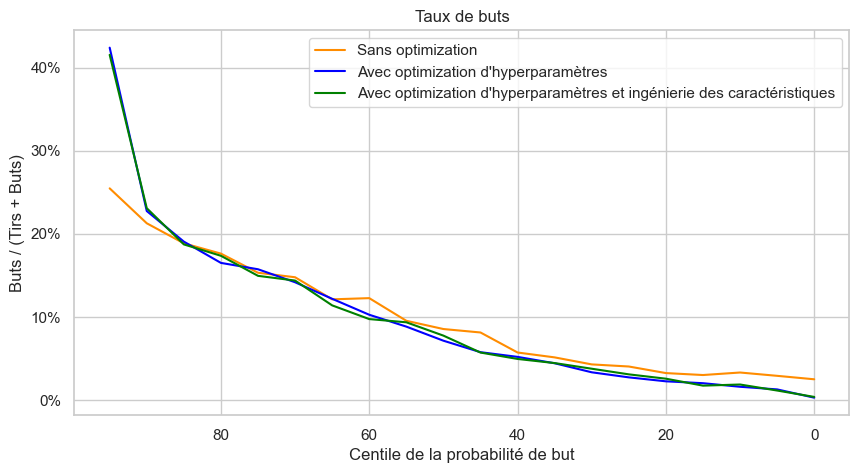

In [18]:
def plot_goal_rates(results, label, color):
    gr_df = results.copy()
    percentile_bins = np.linspace(0, 1, 21)
    gr_df['percentile'] = pd.qcut(
        gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]
    )
    goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()
    plt.plot(percentile_bins[:-1], goal_rates, color=color, label=label)

plt.figure(figsize=(10, 5))

plot_goal_rates(results_v0, label="Sans optimization", color='darkorange')
plot_goal_rates(results_v1, label="Avec optimization d'hyperparamètres", color='blue')
plot_goal_rates(results_v2, label="Avec optimization d'hyperparamètres et ingénierie des caractéristiques", color='green')

plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(figpath, "taux_de_buts.png"))
plt.show()

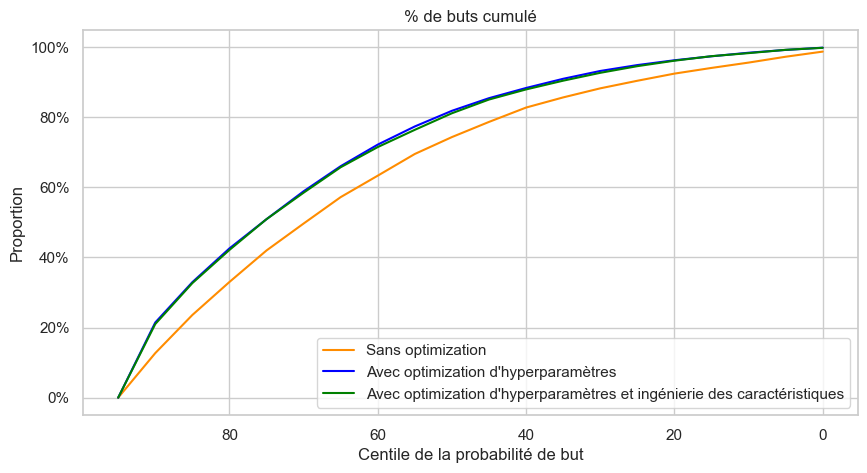

In [19]:
def plot_cumulative_goals(results, label, color):
    cg_df = results.copy()
    percentile_bins = np.linspace(0, 1, 21)
    cg_df['percentile'] = pd.qcut(
        cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]
    )
    total_goals = cg_df['is_goal'].sum()
    goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_goals
    plt.plot(percentile_bins[:-1], goals_cums, color=color, label=label)

plt.figure(figsize=(10, 5))

plot_cumulative_goals(results_v0, label="Sans optimization", color='darkorange')
plot_cumulative_goals(results_v1, label="Avec optimization d'hyperparamètres", color='blue')
plot_cumulative_goals(results_v2, label="Avec optimization d'hyperparamètres et ingénierie des caractéristiques", color='green')

plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))

plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')

plt.legend()
plt.grid(True)

plt.savefig(os.path.join(figpath, "buts_cumul.png"))
plt.show()


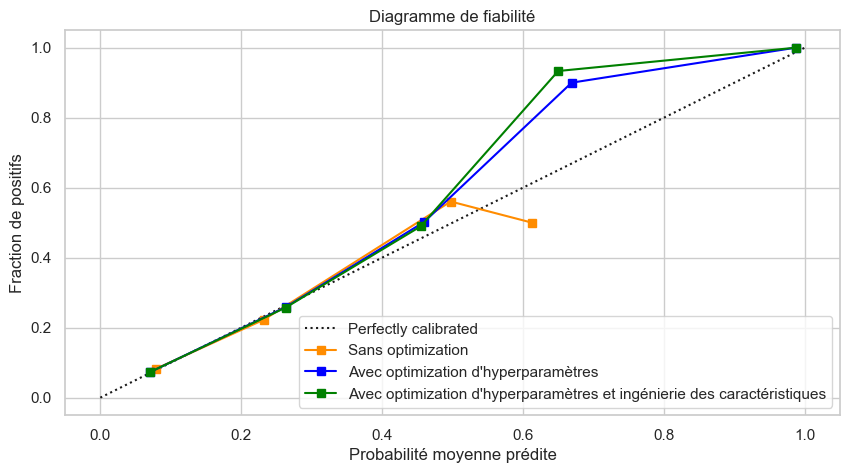

In [21]:
def plot_calibration_curve(results, label, color):
    CalibrationDisplay.from_predictions(
        results['is_goal'],
        results['goal_proba'],
        name=label,
        color=color,
        ax=plt.gca()
    )

plt.figure(figsize=(10, 5))

plot_calibration_curve(results_v0, label="Sans optimization", color='darkorange')
plot_calibration_curve(results_v1, label="Avec optimization d'hyperparamètres", color='blue')
plot_calibration_curve(results_v2, label="Avec optimization d'hyperparamètres et ingénierie des caractéristiques", color='green')

plt.title("Diagramme de fiabilité")
plt.xlabel("Probabilité moyenne prédite")
plt.ylabel("Fraction de positifs")
plt.legend(loc="best")
plt.grid(True)

plt.savefig(os.path.join(figpath, "diag_fiab.png"))
plt.show()